In [77]:
from functools import partial

import numpy as np

import scipy.optimize as spo
from scipy.special import lambertw as lambertW
from scipy.interpolate import interp1d

In [111]:
# Gravitational constant in m / s ^2
g = 9.81

def get_v_components(v0, theta):
    """ Split the initial velocity into its x and y components """
    return (v0 * f(theta) for f in (np.cos, np.sin))

def get_flight_time(v0, theta, vt=None):
    vx, vy = get_v_components(v0, theta)   # x component is not actually used
    
    # Ideal case - solve for non-zero root of -0.5*g*t^2 + vy * t = 0
    if vt is None:
        return 2 * vy / g
    
    # With resistance it's a bit more complicated. The formula below comes from
    # S.M. Stewart, Journal of Engineering Science and Technology Review 4 (1) (2011) 32-34
    # http://www.jestr.org/downloads/volume4/fulltext062011.pdf
    zeta = 1 + (vy / vt)
    print(zeta)
    b_inv = lambda x: -x - lambertW(-x * np.exp(-x))          # Eqn. 9
    
    return (vt / g) * b_inv(zeta)

def point_at_t_ideal(t, theta, v0):
    """
    Calculate point (x, y) in the trajectory at time t (seconds) of an object with initial velocity v0 (meters / second)
    launched at angle theta (radians), approximated in a regime where drag is not a factor
    """
    vx, vy = get_v_components(v0, theta)
    
    xt = vx * t
    yt = t * (vy - 0.5 * g *t)         # The y component has the pull of gravity
    return xt, yt

def point_at_t(t, theta, v0, vt):
    """
    Calculate point (x, y) in the trajectory at time t (seconds) of an object with initial velocity v0 (meters / second)
    launched at angle theta (radians), where the object has terminal velocity vt (meters / second)
    """
    vx, vy = get_v_components(v0, theta)

    decay = 1 - np.exp(-g * t / vt)     # This is a decay factor common to the calculation of both components
    
    # Both components  have changing velocity based on drag and gravitational pull
    # For more information, see: http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node29.html
    xt = (vt / g) * vx * decay
    yt = (vt / g) * (vy + vt) * decay - vt * t
    
    return xt, yt

def time_at_x(dx, theta, v0, vt):
    """ Get the amount of time it takes for the ball to reach dx """    
    # Invert x = (vt * vx / g) * (1 - exp(-g * t / vt))
    vx = v0 * np.cos(theta)
    return -(vt / g) * np.log(1 - ((g * dx) / (vx * vt)))

def get_trajectory(v0, theta, vt=None, n=100):
    """ Returns a plottable trajectory (x_t, y_t) with n points in it """
    # There are two different point-calculating functions, one ideal and one with resistance
    if vt is not None:
        point_func = partial(point_at_t, v0=v0, vt=vt, theta=theta)
    else:
        point_func = partial(point_at_t_ideal, v0=v0, theta=theta)

    t_f = get_flight_time(v0, theta, vt=None)

    # Choose the time points along the trajectory, as x and y are parametrized on t
    t = np.linspace(0, t_f, n)
    
    # This will return (x_t, y_t) where x_t and y_t are numpy arrays
    return point_func(t)


# These functions are used to find the optimal angle
def get_theta_ideal(v0, dx, dy, sgn=-1):
    """
    The ideal case has up to 2 simple closed-form solutions (a negative and a positive root)
    """
    # Just to make this less messy, I'm going to break the formula up into parts
    u = v0 ** 2         # This is the basic velocity unit here
    gx = g * dx
    
    gamma = np.sqrt((u ** 2) - g * ((gx * dx) + (2 * dy * u)))
    p = (u + sgn * gamma) / gx
    
    return np.arctan(p)



In [49]:
def get_theta(v0, dx, dy, vt=None, sgn=-1):
    """
    Find the optimal angle *theta* to use when shooting for point (dx, dy), with terminal velocity vt.
    
    Since there are usually two roots, use sgn to choose the negative or positive root.
    """
    
    # We'll start with the ideal case angle
    th0 = get_theta_ideal(v0, dx, dy, sgn=sgn)
    if vt is None:
        return th0
    
    # We know how to calculate the point at a given time as a function of the angle,
    # so first we should figure out how much time it takes to get to the goal
    
    # Bind the values of these functions that won't change
    get_dt = partial(time_at_x, dx, v0=v0, vt=vt)             # prototype: get_dt(theta)
    get_point = partial(point_at_t, v0=v0, vt=vt)      # prototype: get_point(t, theta)
    
    def y(th):
        # For a given theta, calculate y at dx
        return get_point(get_dt(th), th)[1]
    
    def y_err(th):
        # This function calculates the error off our ideal 
        return abs(y(th) - dy)
    
    res = spo.minimize(y_err, x0=[th0], method='TNC')
    
    return res.x[0]


In [18]:
class ReferenceFrame(object):
    """
    This is a helper class to make it easier to do calculations in one frame of reference and display results in
    another frame of reference.
    """
    def __init__(self, robot_position, shooter_dx, shooter_dy):
        """ robot_position is the position of the backmost part of the robot """
        self.x0 = robot_position + shooter_dx
        self.y0 = shooter_dy
    
    def from_frame(self, x, y):
        return x + self.x0, y + self.y0
    
    def to_frame(self, x, y):
        return x - self.x0, y - self.y0

In [88]:
# Characteristics of the field
goal_bottom = 2.159              # Distance from the ground to the bottom of the goal in meters
goal_height = 0.609              # Height of the goal in meters

field_length = 0.4878            # Maximum shooting distance in meters
pit_ceiling = (goal_height + goal_bottom) * 1.25

# Characteristics of the ball
ball_radius = 0.127              # Ball radius in meters
ball_mass = 0.2945               # Mass of the ball in kg
ball_C = 0.5                     # Numeric drag coefficient of the ball (sphere = 0.5)

# Constants
rho_air = 1.29                         # Viscosity of air in kg / m^3

# Derived values
ball_CA = np.pi * (ball_radius) ** 2     # Cross-sectional area of the ball in m^2
ball_vt = np.sqrt((2 * ball_mass * g) / (ball_C * rho_air * ball_CA))    # Terminal velocity of the ball in m / s

# Functions for getting relevant characteristics
def goal_limits():
    """
    Returns the points between which the center of a ball can pass to score a goal.
    
    Return value is in the format (goal_x, (min_y, max_y))
    """
    goal_x = field_length
    min_y = goal_bottom + ball_radius
    max_y = goal_bottom + goal_height - ball_radius
    
    return (goal_x, (min_y, max_y))

def goal_in_robot_frame(rf, aim=0.5):
    """
    Gets the goal position in the robot's frame of reference.
    
    rf should be a ReferenceFrame (the robot's)
    aim is the fraction of the goal height you are aiming for (0.5 is aiming for the center of the goal,
    1.0 is aiming for the top, 0.0 is aiming for the bottom).
    """
    goal_x, (min_y, max_y) = goal_limits()
    h_aim = min_y + (max_y - min_y) * aim
    
    return rf.to_frame(goal_x, h_aim)

def goal_scored(x_t, y_t):
    """ Pass the x and y trajectories in the lab frame and this gets a binary failure or success """
    goal_x, (min_y, max_y) = goal_limits()
    
    # Automatic failure conditions
    if x_t.max() < goal_x or y_t.max() < min_y:
        return False
    
    # Get the last index in x that is before the goal
    ii = np.where(x_t <= goal_x)[0][-1]
    
    # Get the point before and after the goal
    xx = x_t[ii:(ii + 1)]
    yy = y_t[ii:(ii + 2)]
    
    f = interp1d(xx, yy)        # Make an interpolation function
    
    # Evaluate the interpolation function at the goal x and check if it's in the right place
    return min_y < f(goal_x) < max_y

(0, 0.51219)


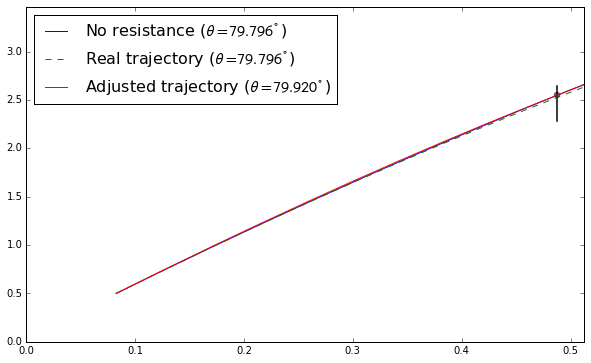

In [142]:
# Robot parameters
dflt_v = 8                 # Initial velocity of the ball, in m / s
dflt_aim = 0.5
dflt_pos = 0.25

robot_width = 0.0      # Robot width in meters. 1 foot = 0.3048 meters
robot_height = 0.5     # Shooter height in meters

# Plot the results
from IPython.html.widgets import interact, interactive, FloatSlider
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['mathtext.fontset'] = 'stixsans'

def plot_trajectories(v, r_pos, aim_frac):
    r_pos *= field_length

    # Create the robot reference frame
    robo_frame = ReferenceFrame(r_pos, shooter_dx=robot_width, shooter_dy=robot_height)

    gx, gy = goal_in_robot_frame(robo_frame, aim=aim_frac)
    glx, gly = robo_frame.from_frame(gx, gy)                # Same thing, in the lab frame
    glx, (gly_min, gly_max) = goal_limits()

    # Calculate the optimal value for theta with and without drag
    croot = -1
    th_n = get_theta(v, gx, gy, sgn=croot)
    th_d = get_theta(v, gx, gy, vt=ball_vt, sgn=croot)

    # Calculate the trajectory of the ball
    get_traj = lambda *args, **kwargs: robo_frame.from_frame(*get_trajectory(*args, **kwargs))

    xtn, ytn = get_traj(v, th_n)
    xte, yte = get_traj(v, th_n, vt=ball_vt)   # Use the ideal angle in the wind resistance case
    xtd, ytd = get_traj(v, th_d, vt=ball_vt)   # The wind resistance case with the correct angle

    # Start plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    
    # Draw the goal that we're aiming for
    ax.scatter(glx, gly, c='k', s=30, alpha=0.5)
    ax.plot([glx, glx], [gly_min, gly_max], 'k-', lw=1.5)

    # Plot the trajectory
    to_deg = lambda x: x * 180 / np.pi
    
    n_line, = ax.plot(xtn, ytn, label='No resistance ($\\theta = {:0.3f}^\\circ$)'.format(to_deg(th_n)))
    e_line, = ax.plot(xte, yte, '--', label='Real trajectory ($\\theta = {:0.3f}^\\circ$)'.format(to_deg(th_n)))
    d_line, = ax.plot(xtd, ytd, label='Adjusted trajectory ($\\theta = {:0.3f}^\\circ$)'.format(to_deg(th_d)))
    
    # Adjust the plots now
    ax.set_xlim((0, glx * 1.05))
    ax.set_ylim((0, pit_ceiling))
    print((0, glx * 1.05))

    ax.legend(loc='best', fontsize=16)
    #plt.tight_layout()
    fig.canvas.draw()
    plt.show()


v_widget = FloatSlider(min=6.0, max=25, step=0.05, value=dflt_v)
pos_widget = FloatSlider(min=0, max=1, step=0.01, value=dflt_pos)
aim_widget = FloatSlider(min=0, max=1, step=0.01, value=dflt_aim)

w = interact(plot_trajectories, v=v_widget, r_pos=pos_widget, aim_frac=aim_widget)
